In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2096, 4) (1426, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 51s 51s/step - loss: 12727.3066
Epoch 2/4000
1/1 [==============================] - 0s 16ms/step - loss: 12675.8242
Epoch 3/4000
1/1 [==============================] - 0s 14ms/step - loss: 12638.6250
Epoch 4/4000
1/1 [==============================] - 0s 13ms/step - loss: 12607.2598
Epoch 5/4000
1/1 [==============================] - 0s 13ms/step - loss: 12579.0400
Epoch 6/4000
1/1 [==============================] - 0s 12ms/step - loss: 12552.6953
Epoch 7/4000
1/1 [==============================] - 0s 13ms/step - loss: 12527.5605
Epoch 8/4000
1/1 [==============================] - 0s 15ms/step - loss: 12503.2812
Epoch 9/4000
1/1 [==============================] - 0s 14ms/step - loss: 12479.6680
Epoch 10/4000
1/1 [==============================] - 0s 13ms/step - loss: 12456.6113
Epoch 11/4000
1/1 [==============================] - 0s 35ms/step - loss: 12434.0371
Epoch 12/4000
1/1 [==============================] - 0s 13ms/step - loss: 

1/1 [==============================] - 0s 21ms/step - loss: 10220.1270
Epoch 193/4000
1/1 [==============================] - 0s 21ms/step - loss: 10212.6797
Epoch 194/4000
1/1 [==============================] - 0s 20ms/step - loss: 10205.2646
Epoch 195/4000
1/1 [==============================] - 0s 20ms/step - loss: 10197.8779
Epoch 196/4000
1/1 [==============================] - 0s 19ms/step - loss: 10190.5195
Epoch 197/4000
1/1 [==============================] - 0s 20ms/step - loss: 10183.1895
Epoch 198/4000
1/1 [==============================] - 0s 20ms/step - loss: 10175.8887
Epoch 199/4000
1/1 [==============================] - 0s 20ms/step - loss: 10168.6172
Epoch 200/4000
1/1 [==============================] - 0s 20ms/step - loss: 10161.3740
Epoch 201/4000
1/1 [==============================] - 0s 20ms/step - loss: 10154.1562
Epoch 202/4000
1/1 [==============================] - 0s 20ms/step - loss: 10146.9668
Epoch 203/4000
1/1 [==============================] - 0s 19ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 8944.1152
Epoch 385/4000
1/1 [==============================] - 0s 20ms/step - loss: 8937.5264
Epoch 386/4000
1/1 [==============================] - 0s 19ms/step - loss: 8930.9453
Epoch 387/4000
1/1 [==============================] - 0s 19ms/step - loss: 8924.3652
Epoch 388/4000
1/1 [==============================] - 0s 20ms/step - loss: 8917.7969
Epoch 389/4000
1/1 [==============================] - 0s 20ms/step - loss: 8911.2266
Epoch 390/4000
1/1 [==============================] - 0s 19ms/step - loss: 8904.6699
Epoch 391/4000
1/1 [==============================] - 0s 19ms/step - loss: 8898.1113
Epoch 392/4000
1/1 [==============================] - 0s 20ms/step - loss: 8891.5674
Epoch 393/4000
1/1 [==============================] - 0s 19ms/step - loss: 8885.0215
Epoch 394/4000
1/1 [==============================] - 0s 20ms/step - loss: 8878.4893
Epoch 395/4000
1/1 [==============================] - 0s 20ms/step - loss: 8871.

1/1 [==============================] - 0s 19ms/step - loss: 7857.5039
Epoch 577/4000
1/1 [==============================] - 0s 20ms/step - loss: 7852.7910
Epoch 578/4000
1/1 [==============================] - 0s 19ms/step - loss: 7848.0674
Epoch 579/4000
1/1 [==============================] - 0s 19ms/step - loss: 7843.3701
Epoch 580/4000
1/1 [==============================] - 0s 20ms/step - loss: 7838.6611
Epoch 581/4000
1/1 [==============================] - 0s 19ms/step - loss: 7833.9805
Epoch 582/4000
1/1 [==============================] - 0s 20ms/step - loss: 7829.2871
Epoch 583/4000
1/1 [==============================] - 0s 20ms/step - loss: 7824.6221
Epoch 584/4000
1/1 [==============================] - 0s 20ms/step - loss: 7819.9453
Epoch 585/4000
1/1 [==============================] - 0s 20ms/step - loss: 7815.2954
Epoch 586/4000
1/1 [==============================] - 0s 20ms/step - loss: 7810.6328
Epoch 587/4000
1/1 [==============================] - 0s 20ms/step - loss: 7805.

1/1 [==============================] - 0s 20ms/step - loss: 7076.8550
Epoch 769/4000
1/1 [==============================] - 0s 20ms/step - loss: 7073.3706
Epoch 770/4000
1/1 [==============================] - 0s 19ms/step - loss: 7069.8945
Epoch 771/4000
1/1 [==============================] - 0s 19ms/step - loss: 7066.4209
Epoch 772/4000
1/1 [==============================] - 0s 20ms/step - loss: 7062.9561
Epoch 773/4000
1/1 [==============================] - 0s 19ms/step - loss: 7059.4932
Epoch 774/4000
1/1 [==============================] - 0s 19ms/step - loss: 7056.0391
Epoch 775/4000
1/1 [==============================] - 0s 19ms/step - loss: 7052.5869
Epoch 776/4000
1/1 [==============================] - 0s 20ms/step - loss: 7049.1440
Epoch 777/4000
1/1 [==============================] - 0s 20ms/step - loss: 7045.7026
Epoch 778/4000
1/1 [==============================] - 0s 20ms/step - loss: 7042.2700
Epoch 779/4000
1/1 [==============================] - 0s 20ms/step - loss: 7038.

1/1 [==============================] - 0s 21ms/step - loss: 6496.6973
Epoch 961/4000
1/1 [==============================] - 0s 20ms/step - loss: 6494.1084
Epoch 962/4000
1/1 [==============================] - 0s 22ms/step - loss: 6491.5479
Epoch 963/4000
1/1 [==============================] - 0s 20ms/step - loss: 6488.9727
Epoch 964/4000
1/1 [==============================] - 0s 21ms/step - loss: 6486.4214
Epoch 965/4000
1/1 [==============================] - 0s 21ms/step - loss: 6483.8560
Epoch 966/4000
1/1 [==============================] - 0s 21ms/step - loss: 6481.3154
Epoch 967/4000
1/1 [==============================] - 0s 21ms/step - loss: 6478.7603
Epoch 968/4000
1/1 [==============================] - 0s 21ms/step - loss: 6476.2305
Epoch 969/4000
1/1 [==============================] - 0s 24ms/step - loss: 6473.6846
Epoch 970/4000
1/1 [==============================] - 0s 21ms/step - loss: 6471.1694
Epoch 971/4000
1/1 [==============================] - 0s 22ms/step - loss: 6468.

1/1 [==============================] - 0s 23ms/step - loss: 6097.4453
Epoch 1151/4000
1/1 [==============================] - 0s 21ms/step - loss: 6095.8159
Epoch 1152/4000
1/1 [==============================] - 0s 21ms/step - loss: 6094.2109
Epoch 1153/4000
1/1 [==============================] - 0s 22ms/step - loss: 6092.5742
Epoch 1154/4000
1/1 [==============================] - 0s 22ms/step - loss: 6090.9702
Epoch 1155/4000
1/1 [==============================] - 0s 25ms/step - loss: 6089.3442
Epoch 1156/4000
1/1 [==============================] - 0s 22ms/step - loss: 6087.7490
Epoch 1157/4000
1/1 [==============================] - 0s 22ms/step - loss: 6086.1504
Epoch 1158/4000
1/1 [==============================] - 0s 23ms/step - loss: 6084.5703
Epoch 1159/4000
1/1 [==============================] - 0s 22ms/step - loss: 6082.9937
Epoch 1160/4000
1/1 [==============================] - 0s 21ms/step - loss: 6081.4146
Epoch 1161/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 19ms/step - loss: 5863.6377
Epoch 1341/4000
1/1 [==============================] - 0s 19ms/step - loss: 5862.7417
Epoch 1342/4000
1/1 [==============================] - 0s 21ms/step - loss: 5861.8398
Epoch 1343/4000
1/1 [==============================] - 0s 20ms/step - loss: 5860.9146
Epoch 1344/4000
1/1 [==============================] - 0s 24ms/step - loss: 5860.0190
Epoch 1345/4000
1/1 [==============================] - 0s 22ms/step - loss: 5859.1074
Epoch 1346/4000
1/1 [==============================] - 0s 22ms/step - loss: 5858.2676
Epoch 1347/4000
1/1 [==============================] - 0s 21ms/step - loss: 5857.3730
Epoch 1348/4000
1/1 [==============================] - 0s 21ms/step - loss: 5856.5601
Epoch 1349/4000
1/1 [==============================] - 0s 20ms/step - loss: 5855.6426
Epoch 1350/4000
1/1 [==============================] - 0s 20ms/step - loss: 5854.8105
Epoch 1351/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 5733.1177
Epoch 1531/4000
1/1 [==============================] - 0s 20ms/step - loss: 5732.6650
Epoch 1532/4000
1/1 [==============================] - 0s 20ms/step - loss: 5732.2622
Epoch 1533/4000
1/1 [==============================] - 0s 20ms/step - loss: 5731.7686
Epoch 1534/4000
1/1 [==============================] - 0s 19ms/step - loss: 5731.1460
Epoch 1535/4000
1/1 [==============================] - 0s 20ms/step - loss: 5730.5527
Epoch 1536/4000
1/1 [==============================] - 0s 20ms/step - loss: 5729.9639
Epoch 1537/4000
1/1 [==============================] - 0s 21ms/step - loss: 5729.4121
Epoch 1538/4000
1/1 [==============================] - 0s 20ms/step - loss: 5728.9717
Epoch 1539/4000
1/1 [==============================] - 0s 21ms/step - loss: 5728.5122
Epoch 1540/4000
1/1 [==============================] - 0s 20ms/step - loss: 5728.1831
Epoch 1541/4000
1/1 [==============================] - 0s 20ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 5652.6079
Epoch 1721/4000
1/1 [==============================] - 0s 20ms/step - loss: 5651.6758
Epoch 1722/4000
1/1 [==============================] - 0s 20ms/step - loss: 5651.1719
Epoch 1723/4000
1/1 [==============================] - 0s 19ms/step - loss: 5650.5225
Epoch 1724/4000
1/1 [==============================] - 0s 20ms/step - loss: 5650.3159
Epoch 1725/4000
1/1 [==============================] - 0s 19ms/step - loss: 5649.9912
Epoch 1726/4000
1/1 [==============================] - 0s 19ms/step - loss: 5649.8774
Epoch 1727/4000
1/1 [==============================] - 0s 19ms/step - loss: 5649.6826
Epoch 1728/4000
1/1 [==============================] - 0s 19ms/step - loss: 5649.3716
Epoch 1729/4000
1/1 [==============================] - 0s 19ms/step - loss: 5648.8242
Epoch 1730/4000
1/1 [==============================] - 0s 20ms/step - loss: 5648.3203
Epoch 1731/4000
1/1 [==============================] - 0s 20ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 5593.1562
Epoch 1911/4000
1/1 [==============================] - 0s 20ms/step - loss: 5592.7275
Epoch 1912/4000
1/1 [==============================] - 0s 19ms/step - loss: 5592.7563
Epoch 1913/4000
1/1 [==============================] - 0s 19ms/step - loss: 5593.0332
Epoch 1914/4000
1/1 [==============================] - 0s 20ms/step - loss: 5593.2241
Epoch 1915/4000
1/1 [==============================] - 0s 20ms/step - loss: 5592.8213
Epoch 1916/4000
1/1 [==============================] - 0s 20ms/step - loss: 5592.0967
Epoch 1917/4000
1/1 [==============================] - 0s 19ms/step - loss: 5591.2275
Epoch 1918/4000
1/1 [==============================] - 0s 20ms/step - loss: 5590.9658
Epoch 1919/4000
1/1 [==============================] - 0s 19ms/step - loss: 5590.3594
Epoch 1920/4000
1/1 [==============================] - 0s 20ms/step - loss: 5590.5610
Epoch 1921/4000
1/1 [==============================] - 0s 19ms/step - 

1/1 [==============================] - 0s 22ms/step - loss: 5545.7676
Epoch 2101/4000
1/1 [==============================] - 0s 21ms/step - loss: 5545.5566
Epoch 2102/4000
1/1 [==============================] - 0s 21ms/step - loss: 5545.6367
Epoch 2103/4000
1/1 [==============================] - 0s 21ms/step - loss: 5546.1045
Epoch 2104/4000
1/1 [==============================] - 0s 26ms/step - loss: 5545.4810
Epoch 2105/4000
1/1 [==============================] - 0s 150ms/step - loss: 5545.7256
Epoch 2106/4000
1/1 [==============================] - 0s 116ms/step - loss: 5546.2314
Epoch 2107/4000
1/1 [==============================] - 0s 22ms/step - loss: 5545.3896
Epoch 2108/4000
1/1 [==============================] - 0s 22ms/step - loss: 5552.0293
Epoch 2109/4000
1/1 [==============================] - 0s 23ms/step - loss: 5559.3018
Epoch 2110/4000
1/1 [==============================] - 0s 22ms/step - loss: 5548.2661
Epoch 2111/4000
1/1 [==============================] - 0s 29ms/step 

1/1 [==============================] - 0s 20ms/step - loss: 5511.9922
Epoch 2291/4000
1/1 [==============================] - 0s 21ms/step - loss: 5512.0205
Epoch 2292/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 2293/4000
1/1 [==============================] - 0s 20ms/step - loss: 5516.8232
Epoch 2294/4000
1/1 [==============================] - 0s 20ms/step - loss: 5515.4785
Epoch 2295/4000
1/1 [==============================] - 0s 23ms/step - loss: 5532.6621
Epoch 2296/4000
1/1 [==============================] - 0s 22ms/step - loss: 5515.6865
Epoch 2297/4000
1/1 [==============================] - 0s 21ms/step - loss: 5510.2378
Epoch 2298/4000
1/1 [==============================] - 0s 21ms/step - loss: 5509.9072
Epoch 2299/4000
1/1 [==============================] - 0s 21ms/step - loss: 5508.7637
Epoch 2300/4000
1/1 [==============================] - 0s 21ms/step - loss: 5507.3164
Epoch 2301/4000
1/1 [==============================] - 0s 20ms/step - loss: 

1/1 [==============================] - 0s 22ms/step - loss: 5489.9385
Epoch 2481/4000
1/1 [==============================] - 0s 21ms/step - loss: 5487.7808
Epoch 2482/4000
1/1 [==============================] - 0s 21ms/step - loss: 5487.4375
Epoch 2483/4000
1/1 [==============================] - 0s 19ms/step - loss: 5486.8667
Epoch 2484/4000
1/1 [==============================] - 0s 22ms/step - loss: 5484.2231
Epoch 2485/4000
1/1 [==============================] - 0s 21ms/step - loss: 5486.4648
Epoch 2486/4000
1/1 [==============================] - 0s 20ms/step - loss: 5484.2979
Epoch 2487/4000
1/1 [==============================] - 0s 21ms/step - loss: 5485.0693
Epoch 2488/4000
1/1 [==============================] - 0s 20ms/step - loss: 5485.1689
Epoch 2489/4000
1/1 [==============================] - 0s 21ms/step - loss: 5485.0000
Epoch 2490/4000
1/1 [==============================] - 0s 21ms/step - loss: 5487.5371
Epoch 2491/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 20ms/step - loss: 5466.4287
Epoch 2671/4000
1/1 [==============================] - 0s 20ms/step - loss: 5468.0068
Epoch 2672/4000
1/1 [==============================] - 0s 21ms/step - loss: nan
Epoch 2673/4000
1/1 [==============================] - 0s 20ms/step - loss: 5470.8511
Epoch 2674/4000
1/1 [==============================] - 0s 21ms/step - loss: 5464.2856
Epoch 2675/4000
1/1 [==============================] - 0s 19ms/step - loss: 5464.2563
Epoch 2676/4000
1/1 [==============================] - 0s 21ms/step - loss: 5461.9189
Epoch 2677/4000
1/1 [==============================] - 0s 21ms/step - loss: 5464.9614
Epoch 2678/4000
1/1 [==============================] - 0s 21ms/step - loss: 5463.6484
Epoch 2679/4000
1/1 [==============================] - 0s 20ms/step - loss: 5464.4424
Epoch 2680/4000
1/1 [==============================] - 0s 21ms/step - loss: 5462.6831
Epoch 2681/4000
1/1 [==============================] - 0s 21ms/step - loss: 

1/1 [==============================] - 0s 22ms/step - loss: 5446.8662
Epoch 2861/4000
1/1 [==============================] - 0s 23ms/step - loss: 5450.3154
Epoch 2862/4000
1/1 [==============================] - 0s 21ms/step - loss: 5446.7827
Epoch 2863/4000
1/1 [==============================] - 0s 21ms/step - loss: 5449.6553
Epoch 2864/4000
1/1 [==============================] - 0s 23ms/step - loss: 5446.1650
Epoch 2865/4000
1/1 [==============================] - 0s 22ms/step - loss: 5448.9980
Epoch 2866/4000
1/1 [==============================] - 0s 22ms/step - loss: 5446.1138
Epoch 2867/4000
1/1 [==============================] - 0s 24ms/step - loss: 5448.8555
Epoch 2868/4000
1/1 [==============================] - 0s 50ms/step - loss: 5446.4585
Epoch 2869/4000
1/1 [==============================] - 0s 24ms/step - loss: 5449.5234
Epoch 2870/4000
1/1 [==============================] - 0s 21ms/step - loss: 5446.8252
Epoch 2871/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5434.5298
Epoch 3051/4000
1/1 [==============================] - 0s 21ms/step - loss: 5437.6948
Epoch 3052/4000
1/1 [==============================] - 0s 21ms/step - loss: 5434.6377
Epoch 3053/4000
1/1 [==============================] - 0s 21ms/step - loss: 5437.4512
Epoch 3054/4000
1/1 [==============================] - 0s 21ms/step - loss: 5434.1689
Epoch 3055/4000
1/1 [==============================] - 0s 20ms/step - loss: 5437.2915
Epoch 3056/4000
1/1 [==============================] - 0s 21ms/step - loss: 5433.7266
Epoch 3057/4000
1/1 [==============================] - 0s 21ms/step - loss: 5437.4482
Epoch 3058/4000
1/1 [==============================] - 0s 22ms/step - loss: 5433.8711
Epoch 3059/4000
1/1 [==============================] - 0s 20ms/step - loss: 5437.5132
Epoch 3060/4000
1/1 [==============================] - 0s 20ms/step - loss: 5433.6392
Epoch 3061/4000
1/1 [==============================] - 0s 20ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5421.3159
Epoch 3241/4000
1/1 [==============================] - 0s 21ms/step - loss: 5426.2559
Epoch 3242/4000
1/1 [==============================] - 0s 20ms/step - loss: 5421.2954
Epoch 3243/4000
1/1 [==============================] - 0s 20ms/step - loss: 5426.0645
Epoch 3244/4000
1/1 [==============================] - 0s 21ms/step - loss: 5421.2261
Epoch 3245/4000
1/1 [==============================] - 0s 21ms/step - loss: 5425.2124
Epoch 3246/4000
1/1 [==============================] - 0s 20ms/step - loss: 5421.0928
Epoch 3247/4000
1/1 [==============================] - 0s 20ms/step - loss: 5425.0244
Epoch 3248/4000
1/1 [==============================] - 0s 20ms/step - loss: 5421.4619
Epoch 3249/4000
1/1 [==============================] - 0s 21ms/step - loss: 5425.2109
Epoch 3250/4000
1/1 [==============================] - 0s 21ms/step - loss: 5421.5347
Epoch 3251/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5408.2480
Epoch 3431/4000
1/1 [==============================] - 0s 20ms/step - loss: 5412.8018
Epoch 3432/4000
1/1 [==============================] - 0s 20ms/step - loss: 5408.2021
Epoch 3433/4000
1/1 [==============================] - 0s 19ms/step - loss: 5413.7305
Epoch 3434/4000
1/1 [==============================] - 0s 21ms/step - loss: 5407.8608
Epoch 3435/4000
1/1 [==============================] - 0s 20ms/step - loss: 5413.1191
Epoch 3436/4000
1/1 [==============================] - 0s 20ms/step - loss: 5407.4141
Epoch 3437/4000
1/1 [==============================] - 0s 20ms/step - loss: 5412.3311
Epoch 3438/4000
1/1 [==============================] - 0s 21ms/step - loss: 5407.1909
Epoch 3439/4000
1/1 [==============================] - 0s 20ms/step - loss: 5411.8311
Epoch 3440/4000
1/1 [==============================] - 0s 20ms/step - loss: 5408.0239
Epoch 3441/4000
1/1 [==============================] - 0s 20ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5401.3604
Epoch 3621/4000
1/1 [==============================] - 0s 21ms/step - loss: 5406.2061
Epoch 3622/4000
1/1 [==============================] - 0s 21ms/step - loss: 5401.5835
Epoch 3623/4000
1/1 [==============================] - 0s 20ms/step - loss: 5405.9336
Epoch 3624/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.9297
Epoch 3625/4000
1/1 [==============================] - 0s 21ms/step - loss: 5405.9028
Epoch 3626/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.6318
Epoch 3627/4000
1/1 [==============================] - 0s 21ms/step - loss: 5407.2959
Epoch 3628/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.8916
Epoch 3629/4000
1/1 [==============================] - 0s 21ms/step - loss: 5407.5186
Epoch 3630/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.3647
Epoch 3631/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5395.9307
Epoch 3811/4000
1/1 [==============================] - 0s 21ms/step - loss: 5402.6084
Epoch 3812/4000
1/1 [==============================] - 0s 21ms/step - loss: 5396.2524
Epoch 3813/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.5054
Epoch 3814/4000
1/1 [==============================] - 0s 21ms/step - loss: 5396.0732
Epoch 3815/4000
1/1 [==============================] - 0s 20ms/step - loss: 5399.8550
Epoch 3816/4000
1/1 [==============================] - 0s 21ms/step - loss: 5397.3389
Epoch 3817/4000
1/1 [==============================] - 0s 20ms/step - loss: 5400.6899
Epoch 3818/4000
1/1 [==============================] - 0s 21ms/step - loss: 5395.9883
Epoch 3819/4000
1/1 [==============================] - 0s 21ms/step - loss: 5400.0508
Epoch 3820/4000
1/1 [==============================] - 0s 22ms/step - loss: 5395.2041
Epoch 3821/4000
1/1 [==============================] - 0s 21ms/step - 

1/1 [==============================] - 0s 21ms/step - loss: 5391.7690


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

45/45 [==============================] - 0s 334us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

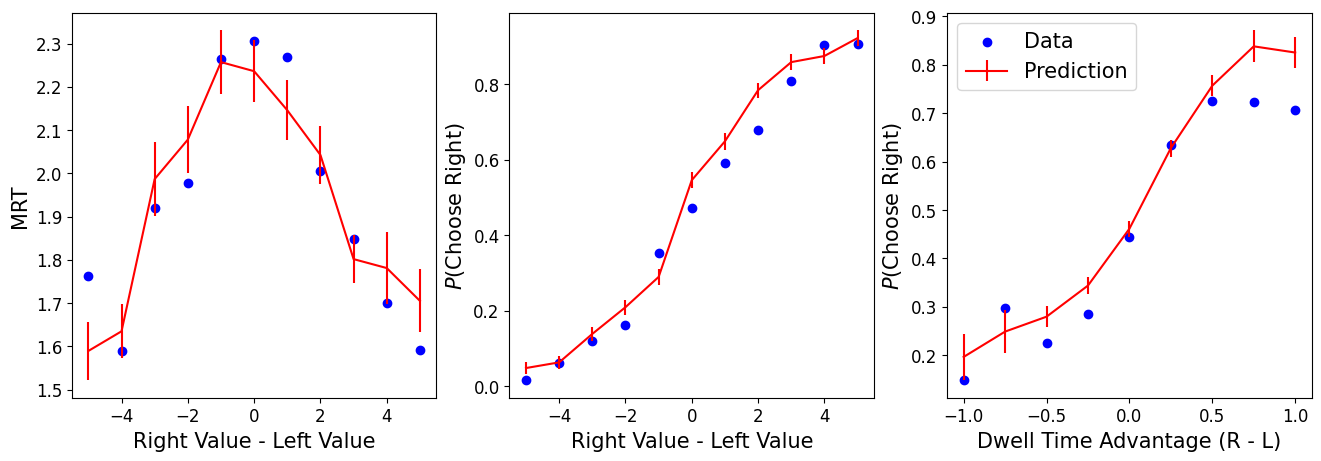

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/kr2010_splitted_postpred.png', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight')
plt.savefig('_plots/kr2010_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

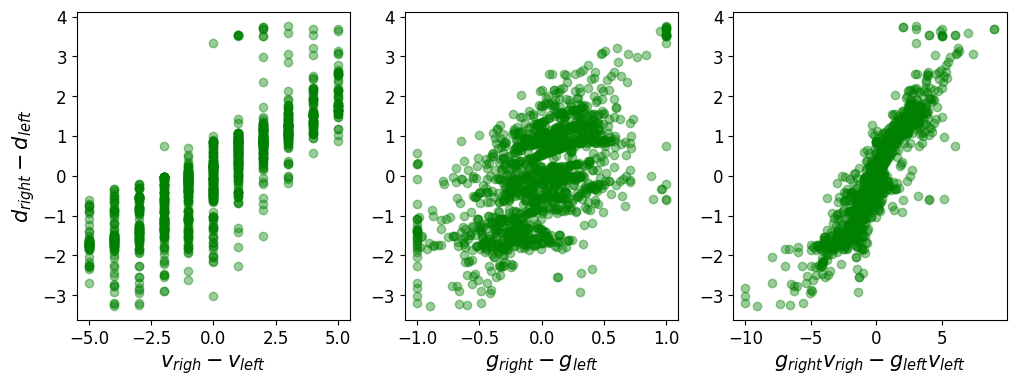

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/kr2010_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');